# Transformer

## 트랜스포머 정의

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
tf.__version__

'2.9.2'

In [ ]:
# 최종 버전
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])

    # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    angle_rads = np.zeros(angle_rads.shape)
    angle_rads[:, 0::2] = sines
    angle_rads[:, 1::2] = cosines
    pos_encoding = tf.constant(angle_rads)
    pos_encoding = pos_encoding[tf.newaxis, ...]

    print(pos_encoding.shape)
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

(1, 50, 128)


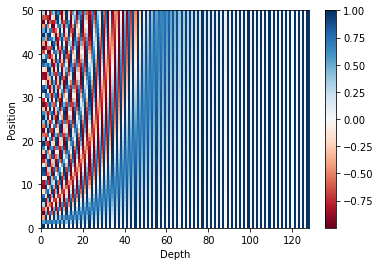

In [ ]:
sample_pos_encoding = PositionalEncoding(50, 128)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [ ]:
def scaled_dot_product_attention(query, key, value, mask):
  # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
  # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
  # padding_mask : (batch_size, 1, 1, key의 문장 길이)

  # Q와 K의 곱. 어텐션 스코어 행렬.
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 스케일링
  # dk의 루트값으로 나눠준다.
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
  # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
  if mask is not None:
    logits += (mask * -1e9)

  # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
  # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  output = tf.matmul(attention_weights, value)

  return output, attention_weights

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    # d_model을 num_heads로 나눈 값.
    # 논문 기준 : 64
    self.depth = d_model // self.num_heads

    # WQ, WK, WV에 해당하는 밀집층 정의
    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    # WO에 해당하는 밀집층 정의
    self.dense = tf.keras.layers.Dense(units=d_model)

  # num_heads 개수만큼 q, k, v를 split하는 함수
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # 1. WQ, WK, WV에 해당하는 밀집층 지나기
    # q : (batch_size, query의 문장 길이, d_model)
    # k : (batch_size, key의 문장 길이, d_model)
    # v : (batch_size, value의 문장 길이, d_model)
    # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 2. 헤드 나누기
    # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
    # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
    # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 4. 헤드 연결(concatenate)하기
    # (batch_size, query의 문장 길이, d_model)
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 5. WO에 해당하는 밀집층 지나기
    # (batch_size, query의 문장 길이, d_model)
    outputs = self.dense(concat_attention)

    return outputs

In [ ]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, key의 문장 길이)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [ ]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': padding_mask # 패딩 마스크 사용
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [ ]:
def encoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 인코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [ ]:
# 디코더의 첫번째 서브층(sublayer)에서 미래 토큰을 Mask하는 함수
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x) # 패딩 마스크도 포함
  return tf.maximum(look_ahead_mask, padding_mask)

In [ ]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 멀티-헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': look_ahead_mask # 룩어헤드 마스크
      })

  # 잔차 연결과 층 정규화
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 멀티-헤드 어텐션 (두번째 서브층 / 디코더-인코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1, 'key': enc_outputs, 'value': enc_outputs, # Q != K = V
          'mask': padding_mask # 패딩 마스크
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [ ]:
def decoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 디코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [ ]:
def transformer(vocab_size, num_layers, dff,
                d_model, num_heads, dropout,
                name="transformer"):

  # 인코더의 입력
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 디코더의 입력
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더의 패딩 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더의 룩어헤드 마스크(첫번째 서브층)
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask, output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 디코더의 패딩 마스크(두번째 서브층)
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
  enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[inputs, enc_padding_mask]) # 인코더의 입력은 입력 문장과 패딩 마스크

  # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
  dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 다음 단어 예측을 위한 출력층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

(1, 9000, 128)
(1, 9000, 128)


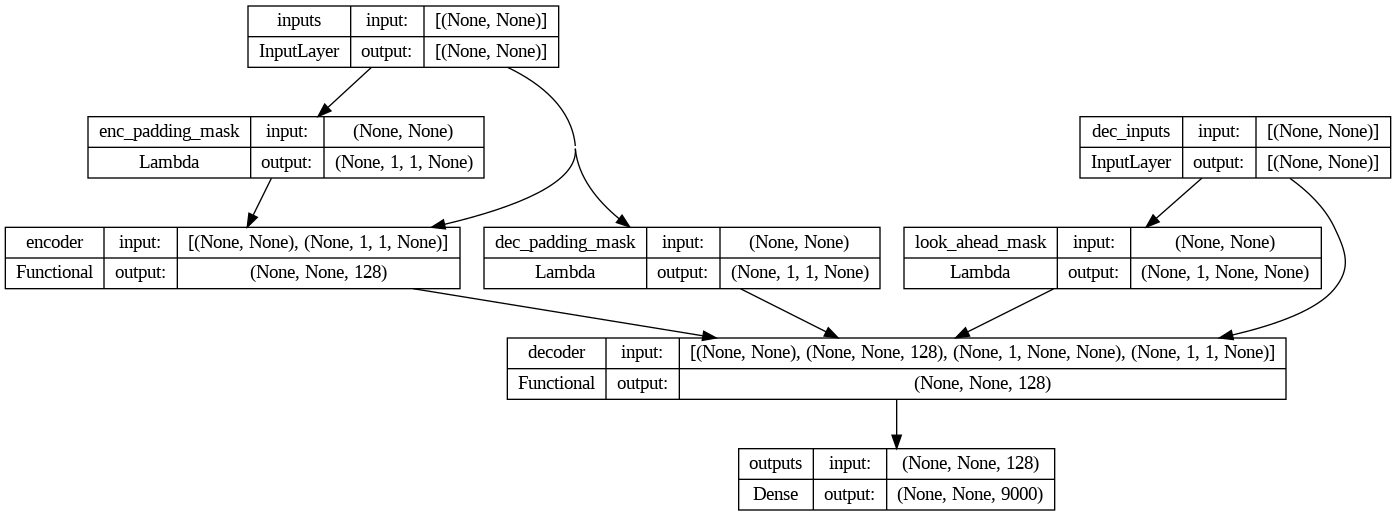

In [ ]:
small_transformer = transformer(
    vocab_size = 9000,
    num_layers = 4,
    dff = 512,
    d_model = 128,
    num_heads = 4,
    dropout = 0.3,
    name="small_transformer")

tf.keras.utils.plot_model(
    small_transformer, to_file='small_transformer.png', show_shapes=True)

In [ ]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

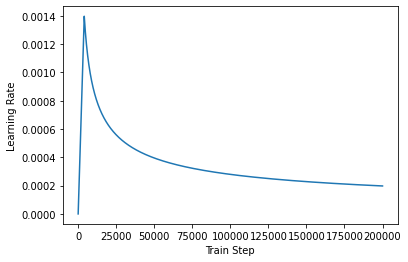

In [ ]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## 모델구현

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 데이터 로드

In [ ]:
import pandas as pd
import urllib.request
import tensorflow_datasets as tfds
import tensorflow as tf
import time
import numpy as np
import matplotlib.pyplot as plt
import re

In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Save_data/Mecab_result4.csv')
train_data.head()


,index_num,reviews,keyword_kor,keyword_num
0,2,곱창과 전골을 추천,곱창,1
1,4,망원 청어람 볶음밥,곱창,1
2,5,가성비 최고 곱창집,곱창,1
3,7,특양구이 대창 갈비,곱창,1
4,8,소곱창구이 황소막창,곱창,1


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22877 entries, 0 to 22876
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   index_num    22877 non-null  int64 
 1   reviews      22877 non-null  object
 2   keyword_kor  22877 non-null  object
 3   keyword_num  22877 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 715.0+ KB


In [ ]:
print('샘플의 개수 :', len(train_data))

샘플의 개수 : 22877


In [ ]:
print(train_data.isnull().sum())

index_num      0
reviews        0
keyword_kor    0
keyword_num    0
dtype: int64


In [ ]:
train_data = train_data.dropna() #결측치 제거

In [ ]:
print('샘플의 개수 :', len(train_data))

샘플의 개수 : 22877


In [ ]:
# 정규표현식사용
reviews = []
for sentence in train_data['reviews']:
    # 구두점에 대해서 띄어쓰기
    # ex) 12시 땡! -> 12시 땡 !
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    reviews.append(sentence)

In [ ]:
reviews = train_data['reviews']
answers = train_data['keyword_kor']

In [ ]:
len(reviews), len(answers)

(22877, 22877)

In [ ]:
print(reviews[:5])
print(answers[:5])

0    곱창과 전골을 추천
1    망원 청어람 볶음밥
2    가성비 최고 곱창집
3    특양구이 대창 갈비
4    소곱창구이 황소막창
Name: reviews, dtype: object
0    곱창
1    곱창
2    곱창
3    곱창
4    곱창
Name: keyword_kor, dtype: object


In [ ]:
reviews[20]

'맛이떠용 깔끔하고 곱창탱탱'

### 단어집합생성

In [ ]:
# 서브워드텍스트인코더를 사용하여 질문과 답변을 모두 포함한 단어 집합(Vocabulary) 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    reviews + answers, target_vocab_size=2**13)

# 시작 토큰과 종료 토큰에 대한 정수 부여.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 단어 집합의 크기를 + 2
VOCAB_SIZE = tokenizer.vocab_size + 2

In [ ]:
print('시작 토큰 번호 :',START_TOKEN)
print('종료 토큰 번호 :',END_TOKEN)
print('단어 집합의 크기 :',VOCAB_SIZE)

시작 토큰 번호 : [8189]
종료 토큰 번호 : [8190]
단어 집합의 크기 : 8191


패딩에 사용될 0번 토큰부터 마지막 토큰인 8,189번 토큰까지의 개수를 카운트하면 단어 집합의 크기는 8,190개입니다.

### 정수 인코딩과 패딩

단어 집합을 생성한 후에는 서브워드텍스트인코더의 토크나이저로 정수 인코딩을 진행할 수 있습니다. 이는 토크나이저의 .encode()를 사용하여 가능합니다. 우선 임의로 선택한 20번 질문 샘플. 즉, questions[20]을 가지고 정수 인코딩을 진행해봅시다.

In [ ]:
# 서브워드텍스트인코더 토크나이저의 .encode()를 사용하여 텍스트 시퀀스를 정수 시퀀스로 변환.
print('임의의 질문 샘플을 정수 인코딩 : {}'.format(tokenizer.encode(reviews[20])))

임의의 질문 샘플을 정수 인코딩 : [401, 1813, 461, 408, 57, 3711]


임의의 질문 문장이 정수 시퀀스로 변환되었습니다. 반대로 정수 인코딩 된 결과는 다시 decode()를 사용하여 기존의 텍스트 시퀀스로 복원할 수 있습니다. 20번 질문 샘플을 가지고 정수 인코딩하고, 다시 이를 디코딩하는 과정은 다음과 같습니다.

In [ ]:
# 서브워드텍스트인코더 토크나이저의 .encode()와 .decode() 테스트해보기
# 임의의 입력 문장을 sample_string에 저장
sample_string = reviews[20]

# encode() : 텍스트 시퀀스 --> 정수 시퀀스
tokenized_string = tokenizer.encode(sample_string)
print ('정수 인코딩 후의 문장 {}'.format(tokenized_string))

# decode() : 정수 시퀀스 --> 텍스트 시퀀스
original_string = tokenizer.decode(tokenized_string)
print ('기존 문장: {}'.format(original_string))

정수 인코딩 후의 문장 [401, 1813, 461, 408, 57, 3711]
기존 문장: 맛이떠용 깔끔하고 곱창탱탱


정수 인코딩 된 문장을 .decode()을 하면 자동으로 서브워드들까지 다시 붙여서 기존 단어로 복원해줍니다. 가령, 정수 인코딩 문장을 보면 정수가 7개인데 기존 문장의 띄어쓰기 단위인 어절은 4개밖에 존재하지 않습니다. 이는 '가스비'나 '비싼데'라는 한 어절이 정수 인코딩 후에는 두 개 이상의 정수일 수 있다는 겁니다. 각 정수가 어떤 서브워드로 맵핑되는지 출력해봅시다.

In [ ]:
# 각 정수는 각 단어와 어떻게 mapping되는지 병렬로 출력
# 서브워드텍스트인코더는 의미있는 단위의 서브워드로 토크나이징한다. 띄어쓰기 단위 X 형태소 분석 단위 X
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

401 ----> 맛이
1813 ----> 떠
461 ----> 용 
408 ----> 깔끔하고 
57 ----> 곱창
3711 ----> 탱탱


샘플 1개를 가지고 정수 인코딩과 디코딩을 수행해보았습니다. 이번에는 전체 데이터에 대해서 정수 인코딩과 패딩을 진행합니다. 이를 위한 함수로 tokenize_and_filter()를 만듭니다. 여기서는 임의로 패딩의 길이는 64으로 정했습니다.

In [ ]:
# 원본
# 최대 길이를 40으로 정의
MAX_LENGTH = 40

# 토큰화 / 정수 인코딩 / 시작 토큰과 종료 토큰 추가 / 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # encode(토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    tokenized_inputs.append(sentence1)
    tokenized_outputs.append(sentence2)

  # 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

  return tokenized_inputs, tokenized_outputs

In [ ]:
reviews, answers = tokenize_and_filter(reviews, answers)

정수 인코딩과 패딩이 진행된 후의 데이터의 크기를 확인해봅시다.

In [ ]:
print('질문 데이터의 크기(shape) :', reviews.shape)
print('답변 데이터의 크기(shape) :', answers.shape)

질문 데이터의 크기(shape) : (22877, 40)
답변 데이터의 크기(shape) : (22877, 40)


질문과 답변 데이터의 모든 문장이 모두 길이 40으로 변환되었습니다. 임의로 0번 샘플을 출력해봅시다.

In [ ]:
# 0번째 샘플을 임의로 출력
print(reviews[0])
print(answers[0])

[8189   57   22 7329  338 8190    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[8189   57 8190    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


### 인코더와 디코더의 입력, 그리고 레이블 만들기

tf.data.Dataset을 사용하여 데이터를 배치 단위로 불러올 수 있습니다.

In [ ]:
# 텐서플로우 dataset을 이용하여 셔플(shuffle)을 수행하되, 배치 크기로 데이터를 묶는다.
# 또한 이 과정에서 교사 강요(teacher forcing)을 사용하기 위해서 디코더의 입력과 실제값 시퀀스를 구성한다.
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': reviews,
        'dec_inputs': answers[:, :-1] # 디코더의 입력. 마지막 패딩 토큰이 제거된다.
    },
    {
        'outputs': answers[:, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다.
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# 임의의 샘플에 대해서 [:, :-1]과 [:, 1:]이 어떤 의미를 가지는지 테스트해본다.
print(answers[0]) # 기존 샘플
print(answers[:1][:, :-1]) # 마지막 패딩 토큰 제거하면서 길이가 63가 된다.
print(answers[:1][:, 1:]) # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다. 길이는 역시 63가 된다.

[8189   57 8190    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[[8189   57 8190    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]
[[  57 8190    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]


### 트랜스포머 만들기

이제 트랜스포머를 만들어봅시다. 하이퍼파라미터를 조정하여 실제 논문의 트랜스포머보다는 작은 모델을 만듭니다.
여기서 선택한 주요 하이퍼파라미터의 값은 다음과 같습니다.

In [ ]:
tf.keras.backend.clear_session()

# Hyper-parameters
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
DFF = 512
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    dff=DFF,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

(1, 8191, 256)
(1, 8191, 256)


학습률과 옵티마이저를 정의하고 모델을 컴파일합니다.

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # 레이블의 크기는 (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3151104     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

총 50회 모델을 학습합니다.

In [ ]:
EPOCHS = 10
model.fit(dataset, epochs=EPOCHS)

Epoch 1/10
358/358 [==============================] - 30s 60ms/step - loss: 0.2713 - accuracy: 0.0235
Epoch 2/10
358/358 [==============================] - 20s 57ms/step - loss: 0.0719 - accuracy: 0.0300
Epoch 3/10
358/358 [==============================] - 21s 58ms/step - loss: 0.0382 - accuracy: 0.0401
Epoch 4/10
358/358 [==============================] - 21s 58ms/step - loss: 0.0272 - accuracy: 0.0431
Epoch 5/10
358/358 [==============================] - 21s 59ms/step - loss: 0.0211 - accuracy: 0.0449
Epoch 6/10
358/358 [==============================] - 21s 58ms/step - loss: 0.0164 - accuracy: 0.0462
Epoch 7/10
358/358 [==============================] - 21s 59ms/step - loss: 0.0130 - accuracy: 0.0473
Epoch 8/10
358/358 [==============================] - 21s 59ms/step - loss: 0.0102 - accuracy: 0.0481
Epoch 9/10
358/358 [==============================] - 21s 59ms/step - loss: 0.0087 - accuracy: 0.0485
Epoch 10/10
358/358 [==============================] - 21s 58ms/step - loss: 0.007

### 모델저장 및 불러오기

In [ ]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 100.2 MB/s eta 0:00:00


In [ ]:
# 텐서플로우사용시
from transformers import TFAutoModelWithLMHead #텐서플로우
tf_model = TFAutoModelWithLMHead.from_pretrained("t5-small")


# 파이토치사용시
# from transformers import BertForMaskedLM #파이토치
# torch_model = BertForMaskedLM.from_pretrained('bert-base-uncased')

###
# fine-tune 과정 수행
###

# 모델 저장 변수 이름.save_pretrained(원하는 디렉토리) 형태
tf_model.save_pretrained('/content/drive/MyDrive/Colab Notebooks/Save_data/Transformer2.model.h5') # 텐서플로우 기반 모델
# torch_model.save_pretrained('model.pt') # 파이토치 기반 모델

# 모델 클래스 이름.from_pretrained(저장된 디렉토리) 형태
# torch_model = BertForMaskedLM.from_pretrained('model.pt') #파이토치
# tf_model = TFAutoModelWithLMHead.from_pretrained('model.h5') #텐서플로우

/usr/local/lib/python3.8/dist-packages/transformers/models/auto/modeling_tf_auto.py:624: FutureWarning: The class `TFAutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `TFAutoModelForCausalLM` for causal language models, `TFAutoModelForMaskedLM` for masked language models and `TFAutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


###  챗봇 평가

챗봇을 평가하기 위한 세 개의 함수를 구현합니다. predict 함수에서 evaluate 함수를 호출하고 evaluate 함수에서 preprocess_sentence 함수를 호출하는 구조입니다. 사용자의 입력이 파이썬의 문자열로 입력되면 preprocess_sentence 함수에서 문자열에 대한 전처리를 수행합니다. 해당 전처리는 학습 전 질문 데이터와 답변 데이터에서 했던 전처리와 동일한 전처리입니다. 전처리가 진행된 문자열에 대해서 evaluate 함수는 트랜스포머 모델에 전처리가 진행된 사용자의 입력을 전달하고, 디코더를 통해 계속해서 현재 시점의 예측. 다시 말해 챗봇의 대답에 해당하는 단어를 순차적으로 예측합니다. 여기서 예측된 단어들은 문자열이 아니라 정수인 상태이므로 evaluate 함수가 리턴하는 것은 결과적으로 정수 시퀀스입니다. predict 함수는 evaluate 함수로부터 전달받은 챗봇의 대답에 해당하는 정수 시퀀스를 문자열로 다시 디코딩을 하고 사용자에게 챗봇의 대답을 출력합니다.

In [ ]:
def preprocess_sentence(sentence):
  # 단어와 구두점 사이에 공백 추가.
  # ex) 12시 땡! -> 12시 땡 !
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()
  return sentence

In [ ]:
def evaluate(sentence):
  # 입력 문장에 대한 전처리
  sentence = preprocess_sentence(sentence)

  # 입력 문장에 시작 토큰과 종료 토큰을 추가
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 예측 시작
  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # 현재 시점의 예측 단어를 받아온다.
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 시점의 예측 단어가 종료 토큰이라면 예측을 중단
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 현재 시점의 예측 단어를 output(출력)에 연결한다.
    # output은 for문의 다음 루프에서 디코더의 입력이 된다.
    output = tf.concat([output, predicted_id], axis=-1)

  # 단어 예측이 모두 끝났다면 output을 리턴.
  return tf.squeeze(output, axis=0)

In [ ]:
def predict(sentence):
  prediction = evaluate(sentence)

  # prediction == 디코더가 리턴한 챗봇의 대답에 해당하는 정수 시퀀스
  # tokenizer.decode()를 통해 정수 시퀀스를 문자열로 디코딩.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence

학습된 트랜스포머에 임의로 생각나는 말들을 적어보았습니다.

### 테스트문장으로 확인

In [ ]:
# 테스트1
output = predict("돼지고기 육즙가득")

Input: 돼지고기 육즙가득
Output: 중식


In [ ]:
# 테스트2
output = predict("반찬이 있고 불고기같은게 먹고싶어")

Input: 반찬이 있고 불고기같은게 먹고싶어
Output: 한식


In [ ]:
# 테스트3
output = predict("딸기맛 아이스크림이 있는게 끌려")

Input: 딸기맛 아이스크림이 있는게 끌려
Output: 디저트


In [ ]:
# 테스트4
output = predict("달콤한게 뭐가있을까?")

Input: 달콤한게 뭐가있을까?
Output: 타코


In [ ]:
# 테스트5
output = predict("크림이 가득한 디저트가 먹고싶어")

Input: 크림이 가득한 디저트가 먹고싶어
Output: 베이커리


In [ ]:
# 테스트6
output = predict("말랑말랑하고 달작지근한거 먹고싶다")

Input: 말랑말랑하고 달작지근한거 먹고싶다
Output: 치킨


In [ ]:
# 테스트7
output = predict("여자친구랑 갈만한곳 추천해줘")

Input: 여자친구랑 갈만한곳 추천해줘
Output: 전골


In [ ]:
# 테스트7
output = predict("부모님 모시고 갈만한 곳 알려줘")

In [ ]:
# 테스트7
output = predict("뭔가 매콤하면서도 쫄깃하고 쫀득한걸 추천해줄래?")

In [ ]:
# 테스트7
output = predict("달콤한게 뭐가있을까?")

# BERT

## 17-02 버트(Bidirectional Encoder Representations from Transformers, BERT)

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 13.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased") # Bert-base의 토크나이저

In [3]:
result = tokenizer.tokenize('Here is the sentence I want embeddings for.')
print(result)

['here', 'is', 'the', 'sentence', 'i', 'want', 'em', '##bed', '##ding', '##s', 'for', '.']


In [4]:
print(tokenizer.vocab['here'])

2182


In [5]:
print(tokenizer.vocab['embeddings'])
# key Error 발생

KeyError: ignored

In [6]:
# 각각의 단어정보확인
print(tokenizer.vocab['em'])
print(tokenizer.vocab['##bed'])
print(tokenizer.vocab['##ding'])
print(tokenizer.vocab['##s'])

7861
8270
4667
2015


In [7]:
# BERT의 단어 집합을 vocabulary.txt에 저장
with open('vocabulary.txt', 'w') as f:
  for token in tokenizer.vocab.keys():
    f.write(token + '\n')

In [13]:
df = pd.read_fwf('vocabulary.txt', header=None)
df

,0
0,[PAD]
1,[unused0]
2,[unused1]
3,[unused2]
4,[unused3]
...,...
30517,##．
30518,##／
30519,##：
30520,##？


In [14]:
print('단어 집합의 크기 :',len(df))

단어 집합의 크기 : 30522


In [15]:
df.loc[4667].values[0]

'##ding'

[PAD] - 0
[UNK] - 100
[CLS] - 101
[SEP] - 102
[MASK] - 103

In [16]:
df.loc[102].values[0]

'[SEP]'

## 17-03 구글 BERT의 마스크드 언어 모델(Masked Language Model) 실습

In [17]:
# 사용하는 모델과 짝 토크나이저를 임포트
from transformers import TFBertForMaskedLM
from transformers import AutoTokenizer

In [18]:
model = TFBertForMaskedLM.from_pretrained('bert-large-uncased')
tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased")

All model checkpoint layers were used when initializing TFBertForMaskedLM.

All the layers of TFBertForMaskedLM were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


In [19]:
inputs = tokenizer('Soccer is a really fun [MASK].', return_tensors='tf')

In [20]:
print(inputs['input_ids']) #토크나이저로 변환

tf.Tensor([[ 101 4715 2003 1037 2428 4569  103 1012  102]], shape=(1, 9), dtype=int32)


In [22]:
print(inputs['token_type_ids']) #세그먼트 인코딩 결과

tf.Tensor([[0 0 0 0 0 0 0 0 0]], shape=(1, 9), dtype=int32)


In [23]:
print(inputs['attention_mask'])

tf.Tensor([[1 1 1 1 1 1 1 1 1]], shape=(1, 9), dtype=int32)


In [24]:
from transformers import FillMaskPipeline
pip = FillMaskPipeline(model=model, tokenizer=tokenizer)

In [25]:
pip('Soccer is a really fun [MASK].')

[{'score': 0.7621126770973206,
  'token': 4368,
  'token_str': 'sport',
  'sequence': 'soccer is a really fun sport.'},
 {'score': 0.20341919362545013,
  'token': 2208,
  'token_str': 'game',
  'sequence': 'soccer is a really fun game.'},
 {'score': 0.012208538129925728,
  'token': 2518,
  'token_str': 'thing',
  'sequence': 'soccer is a really fun thing.'},
 {'score': 0.0018630228005349636,
  'token': 4023,
  'token_str': 'activity',
  'sequence': 'soccer is a really fun activity.'},
 {'score': 0.001335486420430243,
  'token': 2492,
  'token_str': 'field',
  'sequence': 'soccer is a really fun field.'}]

In [26]:
pip('The Avengers is a really fun [MASK].')

[{'score': 0.2562899589538574,
  'token': 2265,
  'token_str': 'show',
  'sequence': 'the avengers is a really fun show.'},
 {'score': 0.17284104228019714,
  'token': 3185,
  'token_str': 'movie',
  'sequence': 'the avengers is a really fun movie.'},
 {'score': 0.11107705533504486,
  'token': 2466,
  'token_str': 'story',
  'sequence': 'the avengers is a really fun story.'},
 {'score': 0.07248983532190323,
  'token': 2186,
  'token_str': 'series',
  'sequence': 'the avengers is a really fun series.'},
 {'score': 0.07046636939048767,
  'token': 2143,
  'token_str': 'film',
  'sequence': 'the avengers is a really fun film.'}]

In [27]:
pip('I went to [MASK] this morning.')

[{'score': 0.35730698704719543,
  'token': 2147,
  'token_str': 'work',
  'sequence': 'i went to work this morning.'},
 {'score': 0.2330448478460312,
  'token': 2793,
  'token_str': 'bed',
  'sequence': 'i went to bed this morning.'},
 {'score': 0.1284504383802414,
  'token': 2082,
  'token_str': 'school',
  'sequence': 'i went to school this morning.'},
 {'score': 0.062305789440870285,
  'token': 3637,
  'token_str': 'sleep',
  'sequence': 'i went to sleep this morning.'},
 {'score': 0.04695258289575577,
  'token': 2465,
  'token_str': 'class',
  'sequence': 'i went to class this morning.'}]

## 17-04 한국어 BERT의 마스크드 언어 모델(Masked Language Model) 실습

In [28]:
from transformers import TFBertForMaskedLM
from transformers import AutoTokenizer

In [29]:
model = TFBertForMaskedLM.from_pretrained('klue/bert-base', from_pt=True)
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForMaskedLM: ['cls.predictions.decoder.bias', 'bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForMaskedLM from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForMaskedLM from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertForMaskedLM were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


In [30]:
inputs = tokenizer('축구는 정말 재미있는 [MASK]다.', return_tensors='tf')

In [31]:
print(inputs['input_ids'])

tf.Tensor([[   2 4713 2259 3944 6001 2259    4  809   18    3]], shape=(1, 10), dtype=int32)


In [32]:
print(inputs['token_type_ids'])

tf.Tensor([[0 0 0 0 0 0 0 0 0 0]], shape=(1, 10), dtype=int32)


In [33]:
print(inputs['attention_mask'])

tf.Tensor([[1 1 1 1 1 1 1 1 1 1]], shape=(1, 10), dtype=int32)


In [34]:
from transformers import FillMaskPipeline
pip = FillMaskPipeline(model=model, tokenizer=tokenizer)

In [35]:
pip('축구는 정말 재미있는 [MASK]다.')

[{'score': 0.8963516354560852,
  'token': 4559,
  'token_str': '스포츠',
  'sequence': '축구는 정말 재미있는 스포츠 다.'},
 {'score': 0.02595745585858822,
  'token': 568,
  'token_str': '거',
  'sequence': '축구는 정말 재미있는 거 다.'},
 {'score': 0.010033913888037205,
  'token': 3682,
  'token_str': '경기',
  'sequence': '축구는 정말 재미있는 경기 다.'},
 {'score': 0.007924334146082401,
  'token': 4713,
  'token_str': '축구',
  'sequence': '축구는 정말 재미있는 축구 다.'},
 {'score': 0.007844174280762672,
  'token': 5845,
  'token_str': '놀이',
  'sequence': '축구는 정말 재미있는 놀이 다.'}]

In [36]:
pip('어벤져스는 정말 재미있는 [MASK]다.')

[{'score': 0.8382413983345032,
  'token': 3771,
  'token_str': '영화',
  'sequence': '어벤져스는 정말 재미있는 영화 다.'},
 {'score': 0.028275731950998306,
  'token': 568,
  'token_str': '거',
  'sequence': '어벤져스는 정말 재미있는 거 다.'},
 {'score': 0.01718936301767826,
  'token': 4665,
  'token_str': '드라마',
  'sequence': '어벤져스는 정말 재미있는 드라마 다.'},
 {'score': 0.014989727176725864,
  'token': 3758,
  'token_str': '이야기',
  'sequence': '어벤져스는 정말 재미있는 이야기 다.'},
 {'score': 0.009382649324834347,
  'token': 4938,
  'token_str': '장소',
  'sequence': '어벤져스는 정말 재미있는 장소 다.'}]

In [37]:
pip('나는 오늘 아침에 [MASK]에 출근을 했다.')

[{'score': 0.08012557774782181,
  'token': 3769,
  'token_str': '회사',
  'sequence': '나는 오늘 아침에 회사 에 출근을 했다.'},
 {'score': 0.06124049797654152,
  'token': 1,
  'token_str': '[UNK]',
  'sequence': '나는 오늘 아침에 에 출근을 했다.'},
 {'score': 0.01748666912317276,
  'token': 4345,
  'token_str': '공장',
  'sequence': '나는 오늘 아침에 공장 에 출근을 했다.'},
 {'score': 0.0161318127065897,
  'token': 5841,
  'token_str': '사무실',
  'sequence': '나는 오늘 아침에 사무실 에 출근을 했다.'},
 {'score': 0.015360800549387932,
  'token': 3671,
  'token_str': '서울',
  'sequence': '나는 오늘 아침에 서울 에 출근을 했다.'}]

## 17-05 구글 BERT의 다음 문장 예측(Next Sentence Prediction)

In [38]:
# 모델과 토크나이저가 짝이 맞아야 사용가능하다
import tensorflow as tf
from transformers import TFBertForNextSentencePrediction
from transformers import AutoTokenizer

In [39]:
model = TFBertForNextSentencePrediction.from_pretrained('bert-base-uncased')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

All model checkpoint layers were used when initializing TFBertForNextSentencePrediction.

All the layers of TFBertForNextSentencePrediction were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForNextSentencePrediction for predictions without further training.


In [40]:
prompt = "In Italy, pizza served in formal settings, such as at a restaurant, is presented unsliced."
next_sentence = "pizza is eaten with the use of a knife and fork. In casual settings, however, it is cut into wedges to be eaten while held in the hand."

In [41]:
encoding = tokenizer(prompt, next_sentence, return_tensors='tf')

In [42]:
print(encoding['input_ids'])

tf.Tensor(
[[  101  1999  3304  1010 10733  2366  1999  5337 10906  1010  2107  2004
   2012  1037  4825  1010  2003  3591  4895 14540  6610  2094  1012   102
  10733  2003  8828  2007  1996  2224  1997  1037  5442  1998  9292  1012
   1999 10017 10906  1010  2174  1010  2009  2003  3013  2046 17632  2015
   2000  2022  8828  2096  2218  1999  1996  2192  1012   102]], shape=(1, 58), dtype=int32)


In [43]:
print(tokenizer.cls_token, ':', tokenizer.cls_token_id)
print(tokenizer.sep_token, ':' , tokenizer.sep_token_id)

[CLS] : 101
[SEP] : 102


In [44]:
print(tokenizer.decode(encoding['input_ids'][0]))

[CLS] in italy, pizza served in formal settings, such as at a restaurant, is presented unsliced. [SEP] pizza is eaten with the use of a knife and fork. in casual settings, however, it is cut into wedges to be eaten while held in the hand. [SEP]


In [45]:
print(encoding['token_type_ids'])

tf.Tensor(
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]], shape=(1, 58), dtype=int32)


In [46]:
logits = model(encoding['input_ids'], token_type_ids=encoding['token_type_ids'])[0]
softmax = tf.keras.layers.Softmax()
probs = softmax(logits) # softmax를 지나기 전 logits를 출력한다.
print(probs)

tf.Tensor([[9.9999714e-01 2.8381855e-06]], shape=(1, 2), dtype=float32)


In [47]:
print('최종 예측 레이블 :', tf.math.argmax(probs, axis=-1).numpy()) #이진분류로 이어지면 0, 이어지지 않으면 1

최종 예측 레이블 : [0]


In [48]:
# 상관없는 두 개의 문장
prompt = "In Italy, pizza served in formal settings, such as at a restaurant, is presented unsliced."
next_sentence = "The sky is blue due to the shorter wavelength of blue light."
encoding = tokenizer(prompt, next_sentence, return_tensors='tf')

logits = model(encoding['input_ids'], token_type_ids=encoding['token_type_ids'])[0]

softmax = tf.keras.layers.Softmax()
probs = softmax(logits)
print('최종 예측 레이블 :', tf.math.argmax(probs, axis=-1).numpy())

최종 예측 레이블 : [1]


## 17-06 한국어 BERT의 다음 문장 예측(Next Sentence Prediction)

In [49]:
import tensorflow as tf
from transformers import TFBertForNextSentencePrediction
from transformers import AutoTokenizer

In [50]:
model = TFBertForNextSentencePrediction.from_pretrained('klue/bert-base', from_pt=True)
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForNextSentencePrediction: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForNextSentencePrediction from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForNextSentencePrediction from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertForNextSentencePrediction were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForNextSentencePrediction for predictions without further training.


In [51]:
# 이어지는 두 개의 문장
prompt = "2002년 월드컵 축구대회는 일본과 공동으로 개최되었던 세계적인 큰 잔치입니다."
next_sentence = "여행을 가보니 한국의 2002년 월드컵 축구대회의 준비는 완벽했습니다."
encoding = tokenizer(prompt, next_sentence, return_tensors='tf')

logits = model(encoding['input_ids'], token_type_ids=encoding['token_type_ids'])[0]

softmax = tf.keras.layers.Softmax()
probs = softmax(logits)
print('최종 예측 레이블 :', tf.math.argmax(probs, axis=-1).numpy())

최종 예측 레이블 : [0]


In [52]:
# 상관없는 두 개의 문장
prompt = "2002년 월드컵 축구대회는 일본과 공동으로 개최되었던 세계적인 큰 잔치입니다."
next_sentence = "극장가서 로맨스 영화를 보고싶어요"
encoding = tokenizer(prompt, next_sentence, return_tensors='tf')

logits = model(encoding['input_ids'], token_type_ids=encoding['token_type_ids'])[0]

softmax = tf.keras.layers.Softmax()
probs = softmax(logits)
print('최종 예측 레이블 :', tf.math.argmax(probs, axis=-1).numpy())

최종 예측 레이블 : [1]


## 17-07 센텐스버트(Sentence BERT, SBERT)

정리하면 사전 학습된 BERT로부터 문장 벡터를 얻는 방법은 다음과 같이 세 가지가 있습니다.


1.   BERT의 [CLS] 토큰의 출력 벡터를 문장 벡터로 간주한다.
2.   BERT의 모든 단어의 출력 벡터에 대해서 평균 풀링을 수행한 벡터를 문장 벡터로 간주한다.
3.   BERT의 모든 단어의 출력 벡터에 대해서 맥스 풀링을 수행한 벡터를 문장 벡터로 간주한다.








In [ ]:
# SBERT는 기본적으로 BERT의 문장 임베딩의 성능을 우수하게 개선시킨 모델

## 18-01 코랩(Colab)에서 TPU 사용하기

In [1]:
import tensorflow as tf
import os

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

tf.distribute.Strategy는 훈련을 여러 GPU 또는 여러 장비, 여러 TPU로 나누어 처리하기 위한 텐서플로 API입니다.

In [3]:
strategy = tf.distribute.TPUStrategy(resolver) 

In [4]:
#모델의 층을 쌓는 create_model()라는 함수
def create_model():
  return tf.keras.Sequential(
      [tf.keras.layers.Conv2D(256, 3, activation='relu', input_shape=(28, 28, 1)),
       tf.keras.layers.Conv2D(256, 3, activation='relu'),
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(256, activation='relu'),
       tf.keras.layers.Dense(128, activation='relu'),
       tf.keras.layers.Dense(10)])

In [5]:
with strategy.scope():
  model = create_model()
  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['sparse_categorical_accuracy'])

GPU로 사용하려면,
이번 챕터에서 TPU로 실습을 진행한 코드들을 GPU 환경에서 실습하고 싶다면, 위에서 모델의 층을 쌓고, 컴파일하는 코드를 제외한 TPU 진행만을 위한 코드들을 전부 제거해주면 됩니다.

## 18-02 transformers의 모델 클래스 불러오기

In [7]:
# 다대일
# from transformers import TFBertForSequenceClassification

# model = TFBertForSequenceClassification.from_pretrained("모델 이름", num_labels=분류할 레이블의 개수)

In [8]:
# 다대다
# from transformers import TFBertForTokenClassification

# model = TFBertForTokenClassification.from_pretrained("모델 이름", num_labels=분류할 레이블의 개수)

In [9]:
# 질의응답
# from transformers import TFBertForQuestionAnswering

# model = TFBertForQuestionAnswering.from_pretrained('모델 이름')

## 18-08 BERT의 문장 임베딩(SBERT)을 이용한 한국어 챗봇

In [10]:
pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 88.0 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=01144fb4d6270533ac4f3889bea722590bebd42d1bce7c32c0c8759c3d3183aa
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence_transformers


In [11]:
import numpy as np
import pandas as pd
from numpy import dot
from numpy.linalg import norm
import urllib.request
from sentence_transformers import SentenceTransformer

In [12]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv", filename="ChatBotData.csv")
train_data = pd.read_csv('ChatBotData.csv')
train_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [13]:
model = SentenceTransformer('sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens')

In [14]:
#train_data['Q']에 대해서 문장 임베딩 값을 구한 후 embedding이라는 새로운 열에 저장
train_data['embedding'] = train_data.apply(lambda row: model.encode(row.Q), axis = 1)

In [15]:
#두 개의 벡터로부터 코사인 유사도를 구하는 함수 cos_sim를 정의
def cos_sim(A, B):
  return dot(A, B)/(norm(A)*norm(B))

In [18]:
#return_answer 함수는 임의의 질문이 들어오면 해당 질문의 문장 임베딩 값과 챗봇 데이터의 임베딩 열.
#즉, train_data['embedding']에 저장해둔 모든 질문 샘플들의 문장 임베딩 값들을 전부 비교하여 코사인 유사도 값이 가장 높은 질문 샘플을 찾음
#그리고 해당 질문 샘플과 짝이 되는 답변 샘플을 리턴
def return_answer(question):
    embedding = model.encode(question)
    train_data['score'] = train_data.apply(lambda x: cos_sim(x['embedding'], embedding), axis=1)
    return train_data.loc[train_data['score'].idxmax()]['A']

In [19]:
#test1
return_answer('결혼하고싶어')

'좋은 사람이랑 결혼할 수 있을 거예요.'

In [20]:
#test2
return_answer('나랑 커피먹을래?')

'카페인이 필요한 시간인가 봐요.'

In [21]:
#test3
return_answer('반가워')

'저도 반가워요.'

In [22]:
#test4
return_answer('사랑해')

'상대방에게 전해보세요.'

In [23]:
#test5
return_answer('너는 누구니?')

'저는 위로봇입니다.'

In [24]:
#test6
return_answer('너무 짜증나')

'짜증날 땐 짜장면'

In [25]:
#test7
return_answer('화가납니다')

'화를 참는 연습을 해보세요.'

In [26]:
#test8
return_answer('나랑 놀자')

'지금 그러고 있어요.'

In [27]:
#test9
return_answer('나랑 게임하자')

'같이 놀아요.'

In [28]:
#test10
return_answer('출근하기싫어')

'씻고 푹 쉬세요.'

In [29]:
#test11
return_answer('여행가고싶다')

'이김에 떠나보세요.'

In [30]:
#test12
return_answer('너 말 잘한다')

'그런 사람이 있으면 저 좀 소개시켜주세요.'

In [34]:
return_answer('내가 좋아하고 맛있는게 뭘까요?')

'다양하게 경험해보세요.'